In [5]:
from dotenv import load_dotenv
import os
from langchain_openai import OpenAIEmbeddings

# Laden der Umgebungsvariablen aus der .env-Datei

load_dotenv(dotenv_path="/home/fabian/SpassProjekte/langchain_Tutorials/.env")

True

In [6]:
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
print("OpenAI API Key is loaded correctly.") if OPENAI_API_KEY else print("OpenAI API Key is NOT loaded.")

DEEP_SEEK_API_KEY = os.getenv("DEEP_SEEK_API_KEY")
print("DeepSeek API Key is loaded correctly.") if DEEP_SEEK_API_KEY else print("DeepSeek API Key is NOT loaded.")


OpenAI API Key is loaded correctly.
DeepSeek API Key is loaded correctly.


In [7]:
import getpass
import os
from langchain.chat_models import init_chat_model

os.environ["DEEPSEEK_API_KEY"] = DEEP_SEEK_API_KEY
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

In [8]:
import getpass
import os


from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [9]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="Micronova",  # Name der Sammlung
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [2]:
from langchain_community.document_loaders import PyPDFLoader, TextLoader

# Specify the path to your file
file_path = "The_Next_End_of_the_World_PDF.pdf"  # Change to your .txt or .pdf file

if file_path.endswith(".pdf"):
    loader = PyPDFLoader(file_path)
elif file_path.endswith(".txt"):
    loader = TextLoader(file_path)
else:
    raise ValueError("Unsupported file type. Please use a .pdf or .txt file.")

docs = loader.load()

assert len(docs) >= 1
print(f"Total characters: {sum(len(doc.page_content) for doc in docs)}")

parsing for Object Streams


Total characters: 150298


In [3]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 290 sub-documents.


In [10]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['fd9ab0ba-6e1a-4a42-a17f-3c21d4edfee8', '748c0118-e7f1-4b8d-b6d0-bf7589fdb123', 'dd7d3a24-617e-4e69-9b2b-682106e15d61']


In [11]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [21]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate.from_template(
    "Answer the following question with the given context\n\ncontext:\n{context}\n\nquestion:\n{question}\n\nanswer:"
)

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [13]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

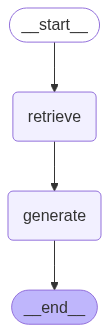

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
result = graph.invoke({"question": "Where will be the new poles of the earth?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='94ac9cc0-38ea-4ff0-ac02-0a86b4b5f06e', metadata={'page_label': '96', 'aapl:keywords': '[]', 'author': 'Ben D', 'keywords': '', 'source': 'The_Next_End_of_the_World_PDF.pdf', 'start_index': 807, 'producer': 'Mac OS X 10.13.6 Quartz PDFContext', 'subject': '', 'creationdate': "D:20210314144439Z00'00'", 'page': 95, 'title': 'The Next End of the World', 'total_pages': 109, 'moddate': '2025-06-26T23:13:17+02:00', 'creator': 'Word'}, page_content='and Siberia. The sloshing-back of the oceans would run well north into the Indian subcontinent and also south of the normal reaches of the Baltic and North Seas.   Not only do Thomas’ new pole positions match the current tracks observable today (which he couldn’t have known), but the event where the internal core-mantle boundary plumes break down and new ones emerge at the poles (like a rare cosmological event) would tilt the earth 90 degrees and relatively back each alternating cycle. I support this scenario most of all. The